In [26]:
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import hiddenlayer
import torchviz
import torch
import torchvision
import torch.utils.data as torch_utils_data
import torchvision.datasets as torchvison_data
import  torchvision.transforms as torchvison_trans
import sklearn.datasets as sklearn_datasets
import sklearn.decomposition as sklearn_decompose
import sklearn.preprocessing as sklearn_processing
import sklearn.metrics as sklearn_metric
import sklearn.manifold as sklearn_manifold
import sklearn.model_selection as sklearn_model_selection
import sklearn.svm as sklearn_svm
import tensorboardX
import seaborn as sns
import copy

In [22]:
# （1）导入数据
root = r"C:\Users\chenb\.torch"
train_data = torchvison_data.MNIST(root=root,train=True,download=True )
test_data = torchvison_data.MNIST(root=root,train=False,download=True )
def process(data):
    x , y = data.data.type(torch.float32)/255.,data.targets
    x = torch.reshape(x,shape=(x.shape[0],-1)) # 向量数据
    return x,y
train_x , train_y = process(train_data)
test_x , test_y = process(test_data)
batch_size = 64
# 因为是无监督学习 无需组合标签
train_loader = torch_utils_data.DataLoader(dataset=train_x,shuffle=True,num_workers=2,batch_size=batch_size)
test_loader = torch_utils_data.DataLoader(dataset=test_x,shuffle=True,num_workers=2,batch_size=batch_size)
train_x.shape

In [24]:
# （2）模型搭建和训练
class MyAutoEncoder(torch.nn.Module):
    def __init__(self):
        super(MyAutoEncoder, self).__init__()
        # 编码器--->降维操作
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 256),
            torch.nn.Tanh(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 3),
            torch.nn.Tanh(), )
        # 解码器--->重构
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3,10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 256),
            torch.nn.Tanh(),
            torch.nn.Linear(256, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 784),
            torch.nn.Sigmoid(), )

    def forward(self,x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder ,decoder
model = MyAutoEncoder()

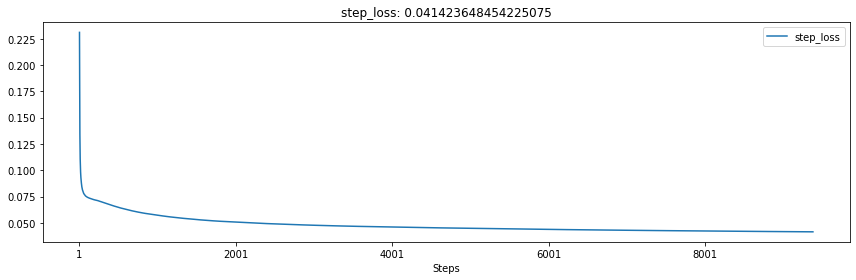

100%|██████████| 10/10 [1:17:45<00:00, 466.54s/it]

epoch=10  step_loss=0.041423648454225075


In [25]:
epochs = 3
history = hiddenlayer.History()
canvas = hiddenlayer.Canvas()
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr=0.003)
total_loss = 0
for epoch in tqdm(range(epochs)):
    model.train()
    for step , b_x, in enumerate(train_loader):
        _,output = model(b_x)
        loss = loss_fn(output,b_x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

        global_step = step + 1 + len(train_loader) * epoch

        step_loss = total_loss / global_step
        
        history.log(global_step,step_loss=step_loss)
        
        with  canvas:
            canvas.draw_plot(history["step_loss"])

    print(f"epoch={epoch + 1}  step_loss={step_loss}")
# batch_size=64, 60000/64 = 938 steps/per epoch 
# global_steps = 938 * epochs 

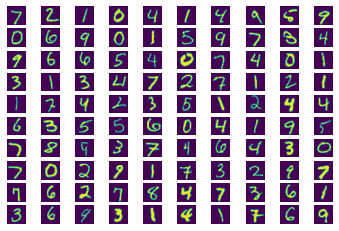

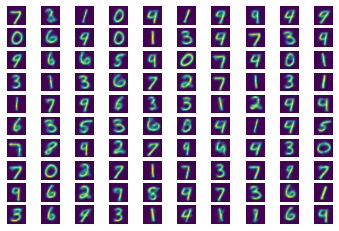

In [42]:
torch.save(model,"C:\\Users\\chenb\\.torch\\MNIST\\mnist_autoEncoder_jupyter.pkl")

# （3）可视化解码后图像和原始图像进行对比
model.eval()
_ , test_decoder = model(test_x[0:100,:])
plt.figure()
for i in range(test_decoder.shape[0]):
    # 原始图像
    plt.subplot(10,10,i+1)
    plt.imshow(test_x[i,:].data.numpy().reshape(28,28))
    plt.axis("off")
plt.show()
plt.figure()
for i in range(test_decoder.shape[0]):
    # 编码-解码图像
    plt.subplot(10,10,i+1)
    plt.imshow(test_decoder[i,:].data.numpy().reshape(28,28))
    plt.axis("off")
plt.show()

c:\users\chenb\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


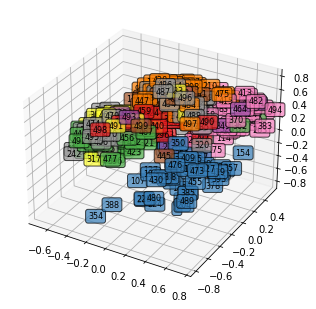

In [38]:
# （4）对编码后解码前的图像可视化
# % config InlineBackend.print_figure_kwargs={'bbox_inches':None}
model.eval()
test_num = 500
test_encoder,_ = model(test_x [0:test_num,:])
fig = plt.figure()
ax = Axes3D(fig)
X ,Y,Z = test_encoder.data.numpy()[:,0],test_encoder.data.numpy()[:,1],test_encoder.data.numpy()[:,2]
ax.set_xlim([min(X),max(X)])
ax.set_ylim([min(Y),max(Y)])
ax.set_zlim([min(Z),max(Z)])

for ii in range(test_encoder.shape[0]):
    text = test_y.data.numpy()[ii] # 类作为文字
    ax.text(X[ii],Y[ii],Z[ii],str(ii),fontsize=8,
              bbox=dict(boxstyle="round",facecolor=plt.cm.Set1(text),alpha=0.7))
plt.show()


In [41]:
# （5）SVM对编码特征进行分类
train_x_encode,_ = model(train_x)# 深度学习变为3维
train_y_encode = train_y.data.numpy()
test_x_encode,_ = model(test_x)
test_y_encode = test_y.data.numpy()

pca = sklearn_decompose.PCA(n_components=3,random_state=10) # PCA变为3维
train_x_pca = pca.fit_transform(train_x.data.numpy())
train_y_pca = train_y.data.numpy()
test_x_pca = pca.fit_transform(test_x.data.numpy())
test_y_pca = test_y.data.numpy()

# 使用SVM对两类对比分类
# 自编码器的分类情况
svm_encode = sklearn_svm.SVC(kernel='rbf',random_state=123)
svm_encode.fit(train_x_encode.data.numpy() ,train_y_encode)
test_pred = svm_encode.predict(test_x_encode.data.numpy())
print(sklearn_metric.classification_report(test_y_encode,test_pred))
print("accuracy score %.5f" % (sklearn_metric.accuracy_score(y_true=test_y_encode, y_pred=test_pred)))

# PCA的分类情况
svm_pca = sklearn_svm.SVC(kernel='rbf',random_state=123)
svm_pca.fit(train_x_pca,train_y_pca)
test_pred = svm_encode.predict(test_x_pca)
print(sklearn_metric.classification_report(test_y_pca,test_pred))
print("accuracy score %.5f" % (sklearn_metric.accuracy_score(y_true=test_y_pca, y_pred=test_pred)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.98      0.97      0.98      1135
           2       0.84      0.84      0.84      1032
           3       0.74      0.74      0.74      1010
           4       0.66      0.65      0.65       982
           5       0.75      0.68      0.71       892
           6       0.87      0.92      0.89       958
           7       0.91      0.87      0.89      1028
           8       0.72      0.69      0.70       974
           9       0.61      0.68      0.65      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

accuracy score 0.80070
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.12      0.05      0.07      1032
 